In [2]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as integrate
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import pandas as pd
from pandas import DataFrame, Series
import heapq
import os
import csv
import re
import math as math

## Question 1

### Part (a)

In [163]:
os.getcwd()
os.path.exists("data")
filestream = open("data/usincmoms.txt", "r")
lista = list(csv.reader(filestream, delimiter='\t'))

In [164]:
values = [row[0] for row in lista]
bin = [row[1] for row in lista]
bin = [float(x) for x in bin]
values = [float(x) for x in values]
values2 = [float(x) for x in values]
factor = 1000
newbin = [x / factor for x in bin]
newbin2 = [x / factor for x in bin]

In [165]:
i = 197.5
newbin2.pop(41)
newbin2.pop(40)

while i < 345:
    newbin2.append(i+5)
    i+=5

In [166]:
top2 = values[40]/10
top1 = values[41]/20
#print(top1, top2)
del values2[40:]

i = 40
while i<70:
    if i<50:
        values2.append(top2)
    else:
        values2.append(top1)
    i+=1

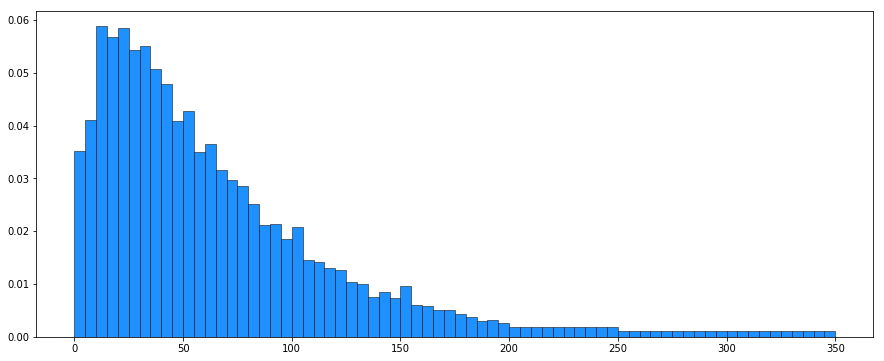

In [167]:
values2 = np.asarray(values2)

fig_size = [0]*2
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.bar(newbin2, values2, width = 5, color = 'dodgerblue', edgecolor = '#000000', linewidth = 0.5, label = 'Data')
plt.show()

### Part (b)

In [168]:
data_mean = newbin2 @ values2.T
var = []
i = 0
while i<70:
    var.append(values2[i]*(newbin2[i]-data_mean)**2)
    i+=1
var = np.asarray(var)
data_var = var.sum()

In [169]:
def log_norm_pdf(x, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, s=sigma, loc=mu)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, s=sigma, loc=mu)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, s=sigma, loc=mu) - sts.lognorm.cdf(cut_lb, s=sigma, loc=mu))

#    pdf_val = sts.lognorm.pdf(x, s=sigma, loc=mu)
        
    pdf_val = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp((-(np.log(x)-mu)**2)/(2*(sigma**2)))/prob_notcut   
    
    return pdf_val

In [170]:
def data_moments2(percent):
    data_moms = percent
    data_moms = np.asarray(data_moms)

    return data_moms


def model_moments2(income, mu, sigma, cut_lb, cut_ub):
    i=0
    model_moms = []
    while i < len(income):
        if i < 40:
            mom, err = integrate.quad(lambda x: log_norm_pdf(x, mu, sigma,cut_lb, cut_ub), income[i]-2.5+1e-8, income[i]+2.5)
            model_moms.append(mom)
            i+=1
        elif i == 40:
            mom, err = integrate.quad(lambda x: log_norm_pdf(x, mu, sigma,cut_lb, cut_ub), income[i]-25, income[i]+25)
            model_moms.append(mom)
            i+=1
        else:
            mom, err = integrate.quad(lambda x: log_norm_pdf(x, mu, sigma,cut_lb, cut_ub), income[i]-50, income[i]+50)
            model_moms.append(mom)
            i+=1
    
    model_moms = np.asarray(model_moms)

    return model_moms


def err_vec2(income, percent, mu, sigma, cut_lb, cut_ub, simple):
    moms_data = data_moments2(percent)
    moms_model = model_moments2(income, mu, sigma, cut_lb, cut_ub)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data

    return err_vec

In [171]:
def matrix_W(income):
    i=0
    matrix = np.zeros((len(income), len(income)))
    while i < len(income):
        matrix[i,i]=income[i]
        i+=1
    return matrix

In [172]:
def criterion(params, *args):
    mu, sigma = params
    income, percent, cut_lb, cut_ub, W = args
    err = err_vec2(income, percent, mu, sigma, cut_lb, cut_ub, simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [173]:
mu_init = np.log(data_mean)
sig_init = 0.2
params_init = np.array([mu_init, sig_init])
W_hat = matrix_W(values)
gmm_args = (newbin, values, 0, 350.0, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol = 1e-5)
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print(results)

mu_GMM1= 3.9241897066275433  sig_GMM1= 0.9807296475426739
      fun: 3.807256741656044e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.32954152e-05, -9.41024033e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 24
      nit: 7
   status: 0
  success: True
        x: array([3.92418971, 0.98072965])


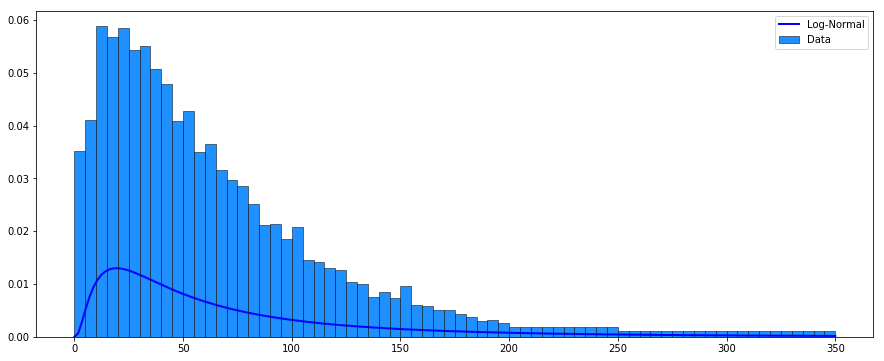

In [174]:
fig_size = [0]*2
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.bar(newbin2, values2, width = 5, color = 'dodgerblue', edgecolor = '#000000', linewidth = 0.5, label='Data')

dist_pts = np.linspace(1e-100, 350, 200) 
pl.plot(dist_pts,log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 0, 350), linewidth=2, color='b', label='Log-Normal')
plt.legend(loc='upper right')
plt.show()

### Part (c)

In [175]:
def gamma_pdf(x, a, b):
    pdf_val = x**(a-1)*np.exp(-x/b)/(math.gamma(a)*(b**a))
    return pdf_val

In [176]:
def data_moments3(percent):
    data_moms = percent
    data_moms = np.asarray(data_moms)

    return data_moms


def model_moments3(income, a, b):
    i=0
    model_moms = []
    while i < len(income):
        if i < 40:
            mom, err = integrate.quad(lambda x: gamma_pdf(x, a, b), income[i]-2.5+1e-8, income[i]+2.5)
            model_moms.append(mom)
            i+=1
        elif i == 40:
            mom, err = integrate.quad(lambda x: gamma_pdf(x, a, b), income[i]-25, income[i]+25)
            model_moms.append(mom)
            i+=1
        else:
            mom, err = integrate.quad(lambda x: gamma_pdf(x, a, b), income[i]-50, income[i]+50)
            model_moms.append(mom)
            i+=1
    
    model_moms = np.asarray(model_moms)

    return model_moms


def err_vec3(income, percent, a, b, simple):
    moms_data = data_moments3(percent)
    moms_model = model_moments3(income, a, b)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data

    return err_vec

In [177]:
def criterion3(params, *args):
    a, b = params
    income, percent, cut_lb, cut_ub, W = args
    err = err_vec3(income, percent, a, b, simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [178]:
a_init = 3.0
b_init = 20.0
params_init = np.array([a_init, b_init])
W_hat = matrix_W(values)
gmm_args = (newbin, values, 1e-10, 350.0, W_hat)
results = opt.minimize(criterion3, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)), tol = 1e-10)
a_GMM, b_GMM = results.x
print('a_GMM=', a_GMM, ' b_GMM=', b_GMM)
print(results)

a_GMM= 1.3984546953723724  b_GMM= 46.48569563745445
      fun: 1.0946992932084281e-05
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.84082878e-10, 1.15196481e-11])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 19
   status: 0
  success: True
        x: array([ 1.3984547 , 46.48569564])


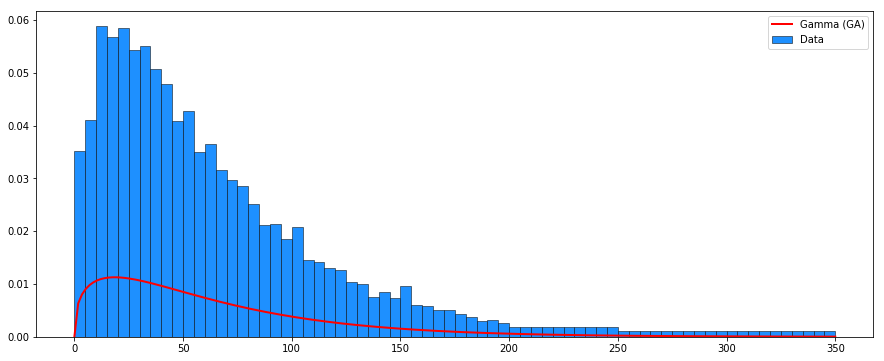

In [179]:
fig_size = [0]*2
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.bar(newbin2, values2, width = 5, color = 'dodgerblue', edgecolor = '#000000', linewidth = 0.5, label='Data')

dist_pts = np.linspace(1e-10, 350, 200) 
pl.plot(dist_pts,gamma_pdf(dist_pts, a_GMM, b_GMM), linewidth=2, color='r', label='Gamma (GA)')
plt.legend(loc='upper right')
plt.show()

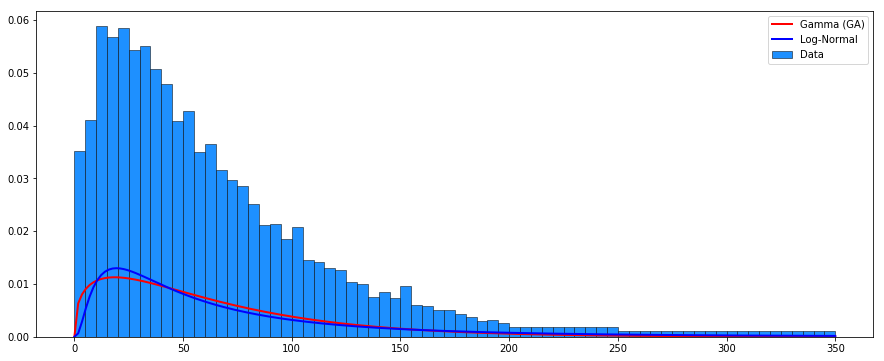

In [180]:
fig_size = [0]*2
fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.bar(newbin2, values2, width = 5, color = 'dodgerblue', edgecolor = '#000000', linewidth = 0.5, label='Data')

dist_pts = np.linspace(1e-10, 350, 200) 
pl.plot(dist_pts,gamma_pdf(dist_pts, a_GMM, b_GMM), linewidth=2, color='r', label='Gamma (GA)')

pl.plot(dist_pts,log_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 1e-10, 350), linewidth=2, color='b', label='Log-Normal')
plt.legend(loc='upper right')
plt.show()

# Comparison between log-normal and Gamma (GA)

In this exercise, the criterion function takes the following values after the minimization process:

Log-Normal criterion value = 3.81e-05

Gamma (GA) criterion value = 1.10e-05

the criterion function for the Gamma is lower than that of the Log-Normal, then the former is a better estimator for the phenomena.


# Question 2

In [3]:
os.getcwd()
os.path.exists("data")
filestream2 = open("data/MacroSeries.txt", "r")

ct=[]
kt=[]
wt=[]
rt=[]

for line in filestream2:
    c, k, w, r = map(float,line.split(','))
    ct.append(c)
    kt.append(k)
    wt.append(w)
    rt.append(r)

Ct=np.asarray(ct)
Kt=np.asarray(kt)
Wt=np.asarray(wt)
Rt=np.asarray(rt)

In [4]:
def eq4(r, k, a):
    value_z4_est = np.log(r/(a*(k**(a-1))))
    return value_z4_est

In [5]:
def moment_1(z_vec, rho, mu):
    i=0
    mom1=[]
    while i<len(z_vec)-2:
        mom1.append(z_vec[i+1]-rho*z_vec[i]-(1-rho)*mu)
        i+=1
    mom1 = np.asarray(mom1)
    exp_value_1 = np.mean(mom1)
    
    return exp_value_1

def moment_2(z_vec, rho, mu):
    i=0
    mom2=[]
    while i<len(z_vec)-2:
        mom2.append((z_vec[i+1]-rho*z_vec[i]-(1-rho)*mu)*z_vec[i])
        i+=1
    mom2 = np.asarray(mom2)
    exp_value_2 = np.mean(mom2)
    
    return exp_value_2

def moment_3(z_vec, k_vec, c_vec, alpha, beta):
    i=0
    mom3=[]
    while i<len(z_vec)-2:
        mom3.append(beta*alpha*np.exp(z_vec[i+1]*k_vec[i+1]**(alpha-1)*c_vec[i]/c_vec[i+1]-1)) 
        i+=1
    mom3 = np.asarray(mom3)
    exp_value_3 = np.mean(mom3)
    
    return exp_value_3
    
def moment_4(z_vec, k_vec, c_vec, w_vec, alpha, beta):
    i=0
    mom4=[]
    while i<len(z_vec)-2:
        mom4.append((beta*alpha*np.exp(z_vec[i+1]*k_vec[i+1]**(alpha-1)*c_vec[i]/c_vec[i+1]-1))*w_vec[i]) 
        i+=1
    mom4 = np.asarray(mom4)
    exp_value_4 = np.mean(mom4)
    
    return exp_value_4


In [6]:
def err_vec_p2(z_vec, k_vec, c_vec, w_vec, alpha, beta, rho, mu, simple):
    moms_data = np.array([moment_1(z_vec, rho, mu), moment_2(z_vec, rho, mu), moment_3(z_vec, k_vec, c_vec, alpha, beta), moment_4(z_vec, k_vec, c_vec, w_vec, alpha, beta)])
    moms_model = np.array([0.0, 0.0, 0.0, 0.0])
    if simple:
        err_vec_p2 = moms_model - moms_data
    else:
        err_vec_p2 = (moms_model - moms_data) / moms_data

    return err_vec_p2

In [7]:
beta_fix = 0.99

In [8]:
def criterion_p2(params, *args):
    z_vec, k_vec, c_vec, w_vec, W = args
    alpha, rho, mu = params
    beta =beta_fix
    err = err_vec_p2(z_vec, k_vec, c_vec, w_vec, alpha, beta, rho, mu, simple=True)
    crit_val = err.T @ W @ err
    
    return crit_val

In [16]:
alpha_in = 0.5
beta_in = beta_fix
rho_in = 0
mu_in = 0.1
Zt=eq4(Rt, Kt, alpha_in)
W_in = np.eye(4)
params_init = np.array([alpha_in, rho_in, mu_in])
gmm_args = (Zt, Kt, Ct, Wt, W_in)
#a=criterion_p2(params_init, gmm_args)
#print(a)
results = opt.minimize(criterion_p2, params_init, args=(gmm_args), method='L-BFGS-B', bounds=((1e-10, 1-1e-10), (-1+1e-10, 1-1e-10), (1e-10, None)))
alpha_opt, rho_opt, mu_opt = results.x
#print(alpha_opt, ro_opt, mu_opt)
print(results)

      fun: 1.3569748163754618e-05
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.45933197e+05, -5.31772091e-01, -1.93123512e-11])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 76
      nit: 4
   status: 0
  success: True
        x: array([1.00000000e-10, 1.00000000e+00, 1.21644794e-01])


### Results:

$\widehat{\alpha}$ = 1.00000000e-10

$\widehat{\beta}$ = 0.99

$\widehat{\rho}$ = 1.00000000e+00

$\widehat{\mu}$ = 1.21655794e-01